# Lane Switch Agents

In [1]:
import sys
sys.path.append('../src')

import matplotlib.pyplot as plt
import numpy as np
import logging
import pandas as pd

from environment_gym import TrafficEnvironment
from task2_environment import CustomTrafficEnvironment
from task2_agents import RuleBasedAgent, TemporalDifference

## Rule-Based Agent

### Evaluation

In [2]:
def evaluate_agent(agent, env, num_episodes=10, starting_lane = 1):
    all_episode_rewards = []
    all_timesteps = []

    for episode in range(num_episodes):
        episode_rewards = []
        
        options = {
            'starting_lane': starting_lane
        }
        state, _ = env.reset(options=options)
        terminated = False
        truncated = False
        cumulative_reward = 0
        timestep = 0
        action_mapping = {0: 'left', 1: 'stay', 2: 'right', 3: 'rest'}

        while not terminated and not truncated:
            action = agent.choose_action(state)
            env.logger.info(f"Action: {action_mapping[action]}")
            next_state, reward, terminated, truncated, _ = env.step(action)
            env.render()
            cumulative_reward += reward
            state = next_state
            timestep += 1
            
            # Store rewards at each timestep for this episode
            episode_rewards.append(cumulative_reward)

            if truncated:
                print('Episode terminated due to reaching maximum timesteps.')
                break

        # Append results for each episode
        all_episode_rewards.append(cumulative_reward)
        all_timesteps.append(timestep)

    return all_episode_rewards, all_timesteps

def plot_eval_metrics(all_episode_rewards, all_timesteps, window_size=10):
    """
    Plot cumulative rewards and timesteps to termination with a rolling mean.

    Args:
    - all_episode_rewards (list of lists): Cumulative rewards for each episode.
    - all_timesteps (list): Number of timesteps to termination for each episode.
    - window_size (int): Window size for rolling mean.
    """
    # Compute rolling mean for cumulative rewards across episodes
    rolling_rewards = pd.DataFrame(all_episode_rewards).mean(axis=0).rolling(window_size).mean()
    # Compute rolling mean for timesteps to termination
    rolling_timesteps = pd.Series(all_timesteps).rolling(window_size).mean()

    # Plot the cumulative rewards with rolling mean
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(rolling_rewards, label='Cumulative Reward (Rolling Mean)')
    plt.xlabel('Timesteps')
    plt.ylabel('Cumulative Reward')
    plt.title(f'Cumulative Rewards Over Episodes (Rolling Mean - Window Size: {window_size})')
    plt.legend()

    # Plot the timesteps to termination with rolling mean
    plt.subplot(1, 2, 2)
    plt.plot(rolling_timesteps, label='Timesteps to Termination (Rolling Mean)')
    plt.xlabel('Episode')
    plt.ylabel('Timesteps')
    plt.title(f'Timesteps to Termination (Rolling Mean - Window Size: {window_size})')
    plt.legend()

    plt.tight_layout()
    plt.show()

### Fastest Adjacent Lane

In [3]:
# Create the environment
env = CustomTrafficEnvironment(max_time_steps=10000, logging_level=logging.CRITICAL)

# Evaluate each strategy
strategy = 'fastest_adjacent'
rewards_dict = {}
timesteps_dict = {}

env.logger.info(f"Evaluating {strategy} strategy")
agent = RuleBasedAgent(strategy=strategy)
# episode_rewards, checkpoint_rewards, timesteps_to_termination = evaluate_agent(agent, env)
all_episode_rewards, all_timesteps = evaluate_agent(agent, env, num_episodes=100)
rewards_dict['Fastest Adjacent Lane Agent'] = all_episode_rewards
timesteps_dict['Fastest Adjacent Lane Agent'] = all_timesteps
# env.logger.info("\n"*5)

In [4]:
print(f'Average cumulative rewards for random strategy: {np.mean(rewards_dict['Fastest Adjacent Lane Agent'])}')
print(f'Average timesteps to termination for random strategy: {np.mean(timesteps_dict["Fastest Adjacent Lane Agent"])}')

Average cumulative rewards for random strategy: 1048.1580000000001
Average timesteps to termination for random strategy: 256.92


### Same Lane

In [5]:
# Create the environment
env = CustomTrafficEnvironment(max_time_steps=10000, logging_level=logging.CRITICAL)

for i in range(5):
    env.logger.info(f"Evaluating Agent {i+1}")
    agent = RuleBasedAgent(strategy='stay')
    all_episode_rewards, all_timesteps = evaluate_agent(agent, env, num_episodes=100, starting_lane=i+1)
    rewards_dict[f'Same Lane Agent {i+1}'] = all_episode_rewards
    timesteps_dict[f'Same Lane Agent {i+1}'] = all_timesteps

In [6]:
for i in range(5):
    print(f'Average cumulative rewards for Same Lane Agent {i+1}: {np.mean(rewards_dict[f"Same Lane Agent {i+1}"])}')
    print(f'Average timesteps to termination for Same Lane Agent {i+1}: {np.mean(timesteps_dict[f"Same Lane Agent {i+1}"])}')

Average cumulative rewards for Same Lane Agent 1: 202.07799999999986
Average timesteps to termination for Same Lane Agent 1: 380.41
Average cumulative rewards for Same Lane Agent 2: 270.2979999999999
Average timesteps to termination for Same Lane Agent 2: 373.62
Average cumulative rewards for Same Lane Agent 3: 209.644
Average timesteps to termination for Same Lane Agent 3: 379.73
Average cumulative rewards for Same Lane Agent 4: -10.907999999999998
Average timesteps to termination for Same Lane Agent 4: 401.77
Average cumulative rewards for Same Lane Agent 5: 263.44500000000005
Average timesteps to termination for Same Lane Agent 5: 374.34


## Value-based Agent

### TD-Lambda

100%|██████████| 300/300 [26:35<00:00,  5.32s/it]


Truncated episodes: 0
Sum of total rewards = -88771.5
Average total reward per episode = -295.905
Average steps per episode = 347.1066666666667


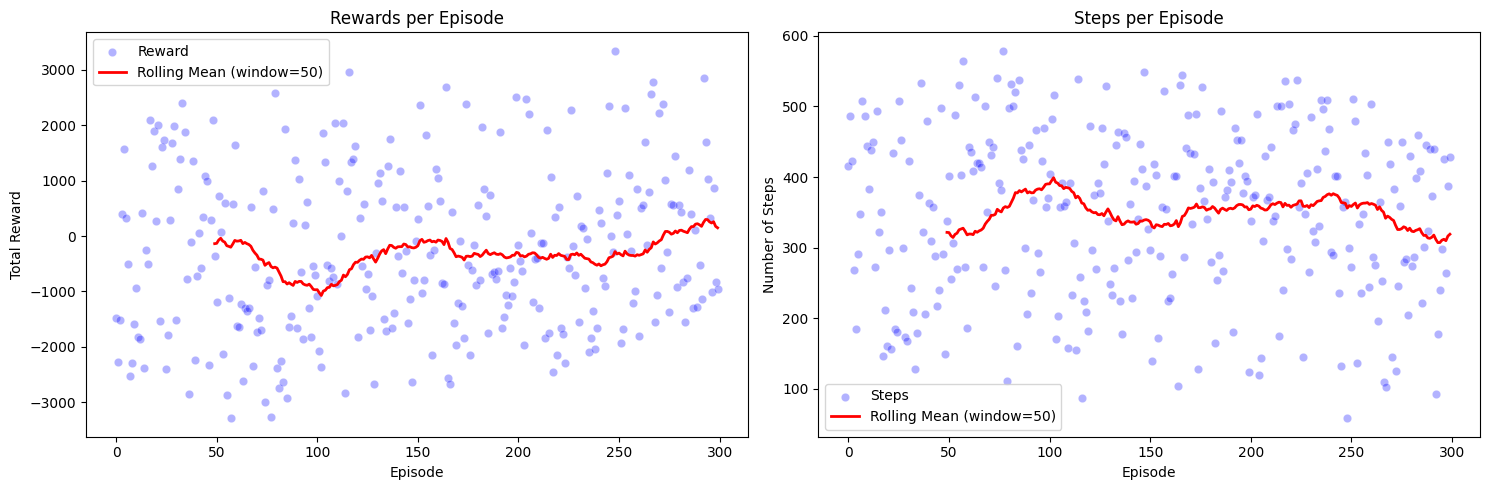

In [12]:
# Create the environment
env = CustomTrafficEnvironment(max_time_steps=10000, logging_level=logging.CRITICAL)

td_lambda = TemporalDifference(env, oiv = 0.1, alpha=0.01, epsilon=0.1, lambd=0.9, gamma=0.9)
total_reward_list, total_steps_list = td_lambda.train(num_episodes = 300, on_policy = True, save_model = False, log=True)
total_rew = sum(total_reward_list)
avg_rew = np.mean(total_reward_list)
avg_steps = np.mean(total_steps_list)

print(f'Sum of total rewards = {total_rew}')
print(f'Average total reward per episode = {avg_rew}')
print(f'Average steps per episode = {avg_steps}')

# plot training metrics
td_lambda.plot_training_metrics(window_size=50)
plt.show()

In [10]:
print(len(td_lambda.Q))

3520


State Space Size = 10 (Distance) x 5 (Lanes) x 2 (Fatigue) x 5 x 5 x 5 (Clearance Rates) x 4 (Actions) = 50,000  
State Space Size = 10 (Distance) x 5 (Lanes) x 5 x 5 x 5 (Clearance Rates) x 3 (Actions) = 18,750

### Evaluation

In [13]:
# Evaluate the agent in inference mode
all_rewards, all_steps, checkpoint_rewards = td_lambda.evaluate(num_episodes=500, checkpoint_interval=50)

# Print the results
print(f"Average Rewards per Episode: {np.mean(all_rewards)}")
print(f"Average Steps per Episode: {np.mean(all_steps)}")

100%|██████████| 500/500 [00:23<00:00, 21.47it/s]

Average Rewards per Episode: 46.44360000000002
Average Steps per Episode: 336.408


## Policy-based Agent